In [29]:
import anndata as ad
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP

In [2]:
adata = ad.read_h5ad("adata.h5ad")
adata

AnnData object with n_obs × n_vars = 665 × 24175
    obs: 'sequenced_by', 'name', 'country', 'lat', 'long', 'collector', 'cs_number', 'admixture_group'

In [3]:
adata.obs

,sequenced_by,name,country,lat,long,collector,cs_number,admixture_group
accession_id,,,,,,,,
108,Monsanto,LDV-18,FRA,48.5167,-4.06667,Valerie Le Corre,CS77013,western_europe
139,Monsanto,LDV-46,FRA,48.5167,-4.06667,Valerie Le Corre,CS77014,western_europe
159,Monsanto,MAR2-3,FRA,47.3500,3.93333,Valerie Le Corre,CS77070,western_europe
265,Monsanto,PYL-6,FRA,44.6500,-1.16667,Valerie Le Corre,CS77198,admixed
350,Monsanto,TOU-A1-88,FRA,46.6667,4.11667,Fabrice Roux,CS77382,western_europe
...,...,...,...,...,...,...,...,...
10017,MPI,ICE21 / Petro-1,SRB,44.3400,21.46000,NaN,CS76370,central_europe
10018,MPI,ICE36 / Dobra-1,SRB,44.8400,20.16000,NaN,CS76369,central_europe
10020,MPI,Jl-2,CZE,49.1700,16.50000,NaN,CS76956,central_europe


In [4]:
adata.var

""
gene_id
AT1G01010
AT1G01020
AT1G01030
AT1G01040
AT1G01046
...
ATMG01360
ATMG01370
ATMG01380


In [6]:
# it's already normalized, but I'm not sure we can trust it

## Loading imputed SNP matrix
https://1001genomes.org/data/GMI-MPI/releases/v3.1/SNP_matrix_imputed_hdf5/

https://1001genomes.org/data/GMI-MPI/releases/v3.1/SNP_matrix_imputed_hdf5/hdf5_demo.py

In [10]:
snps = h5py.File('1001_SNP_MATRIX/imputed_snps_binary.hdf5','r')
snps

<HDF5 file "imputed_snps_binary.hdf5" (mode r)>

In [13]:
# Get all SNP positions for all chromosomes (len=10709949)
positions = snps['positions'][:]
positions.shape

(10709949,)

In [16]:
accessions = snps['accessions'][:]
accessions

array([b'88', b'108', b'139', ..., b'19949', b'19950', b'19951'],
      dtype='|S5')

In [11]:
# Array of tuples with start/stop indices for each chromosome
chr_regions = snps['positions'].attrs['chr_regions']
chr_regions

array([[       0,  2597825],
       [ 2597825,  4466694],
       [ 4466694,  6661059],
       [ 6661059,  8428147],
       [ 8428147, 10709949]])

In [12]:
indices_for_chr5 = chr_regions[4]

In [14]:
# Subset positions for SNPs on Chr5
positions_on_chr5 = positions[indices_for_chr5[0]:indices_for_chr5[1]]
positions_on_chr5

array([      53,       58,       62, ..., 26975445, 26975448, 26975450],
      dtype=int32)

In [15]:
# TODO: make sure there's no +-1 indexing mismatch with our scores

In [150]:
variant_scores = pd.read_parquet("../../plantbert/mlm/vep_full_window-512_tokenization-no_model-convnet800kfinetune200k.parquet")
variant_scores.pos += 1  # for combatibility with SNP matrix
variant_scores["gene_id"] = variant_scores.closest_TSS.str.split(".").str[0]
variant_scores = variant_scores[variant_scores.gene_id.isin(adata.var_names)]
variant_scores = variant_scores.query("consequence == 'upstream_gene_variant'").sort_values("model_llr")
variant_scores

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,gene_id
92757,Chr5,1619494,T,G,4,2030,AT5G05470.1,-965,upstream_gene_variant,-6.559457,AT5G05470
1250250,Chr5,23241224,A,G,4,2104,AT5G57360.1,-204,upstream_gene_variant,-6.419801,AT5G57360
92762,Chr5,1619532,C,G,8,2024,AT5G05470.1,-927,upstream_gene_variant,-6.330372,AT5G05470
697952,Chr5,13698349,G,C,2,2166,AT5G35510.1,-1482,upstream_gene_variant,-6.163540,AT5G35510
1074678,Chr5,20127709,T,C,2,2082,AT5G49580.1,-895,upstream_gene_variant,-6.006138,AT5G49580
...,...,...,...,...,...,...,...,...,...,...,...
1436377,Chr5,26830016,C,T,2,2012,AT5G67245.1,-353,upstream_gene_variant,4.355151,AT5G67245
1167028,Chr5,21791111,C,G,120,2062,AT5G53650.1,-67,upstream_gene_variant,4.462477,AT5G53650
626158,Chr5,12076675,C,T,2028,2078,AT5G32440.3,-219,upstream_gene_variant,4.569783,AT5G32440
820325,Chr5,16110530,C,T,272,2034,AT5G40300.1,-159,upstream_gene_variant,4.716897,AT5G40300


In [151]:
variant_scores.head(20)

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,gene_id
92757,Chr5,1619494,T,G,4,2030,AT5G05470.1,-965,upstream_gene_variant,-6.559457,AT5G05470
1250250,Chr5,23241224,A,G,4,2104,AT5G57360.1,-204,upstream_gene_variant,-6.419801,AT5G57360
92762,Chr5,1619532,C,G,8,2024,AT5G05470.1,-927,upstream_gene_variant,-6.330372,AT5G05470
697952,Chr5,13698349,G,C,2,2166,AT5G35510.1,-1482,upstream_gene_variant,-6.163540,AT5G35510
1074678,Chr5,20127709,T,C,2,2082,AT5G49580.1,-895,upstream_gene_variant,-6.006138,AT5G49580
788906,Chr5,15584902,A,G,2,2002,AT5G38930.1,-172,upstream_gene_variant,-5.830029,AT5G38930
636522,Chr5,12442452,G,C,26,2164,AT5G33210.1,23262,upstream_gene_variant,-5.729167,AT5G33210
1356749,Chr5,25326541,C,G,2,2172,AT5G63135.1,-61,upstream_gene_variant,-5.716648,AT5G63135
1355388,Chr5,25302527,A,C,8,2184,AT5G63080.1,-82,upstream_gene_variant,-5.708972,AT5G63080
466545,Chr5,9077555,A,C,4,2054,AT5G25990.1,-175,upstream_gene_variant,-5.704191,AT5G25990


In [158]:
variant = variant_scores.loc[636522]
variant

chromosome                      Chr5
pos                         12442452
ref                                G
alt                                C
AC                                26
AN                              2164
closest_TSS              AT5G33210.1
dist_to_TSS                    23262
consequence    upstream_gene_variant
model_llr                  -5.729167
gene_id                    AT5G33210
Name: 636522, dtype: object

In [159]:
ix = indices_for_chr5[0] + np.where(positions_on_chr5==variant.pos)[0][0]
ix

9434353

In [160]:
pos_accessions = accessions[np.where(snps["snps"][ix]==1)[0]]
pos_accessions = np.array([pos_accession.decode('UTF-8') for pos_accession in pos_accessions])
pos_accessions

array(['1890', '9616', '9624', '9745', '9957', '9958', '10008', '10009',
       '10010', '14312', '14313', '14314', '14315', '14318'], dtype='<U5')

In [177]:
adata.obs["Condition"] = "Negative"
adata.obs.loc[adata.obs.index.isin(pos_accessions), "Condition"] = "Positive"
adata.obs.Condition.value_counts()

Negative    656
Positive      9
Name: Condition, dtype: int64

KeyError: 'Positive'

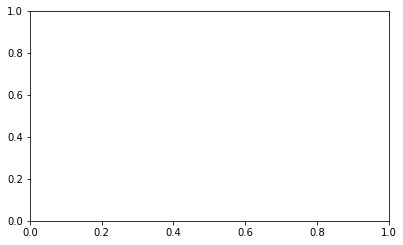

In [178]:
sc.pl.violin(
    adata,
    variant.gene_id,
    groupby="Condition",
)

In [190]:
adata.obs.Condition.value_counts()

Negative    656
Positive      9
Name: Condition, dtype: int64

<AxesSubplot:>

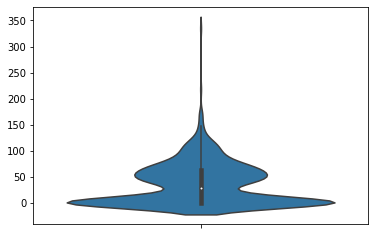

In [188]:
sns.violinplot(
    y=adata[:, variant.gene_id].X.toarray().ravel(),
    hue=adata.obs.Condition,
)

In [186]:
adata[:, variant.gene_id].X.toarray().ravel()

array([ 16.,  66.,  24.,  82.,   1.,   1.,  34., 114.,   0., 143.,   1.,
        23.,   1.,   0.,   0.,   7.,   0.,   0.,   1.,   2.,  30.,  27.,
        47.,  70.,   0.,   0.,   1.,   0.,   1., 110.,   0.,  10.,  67.,
         0.,   0.,   0.,  10.,   0.,  46.,  58.,  72.,   0.,  56.,  46.,
         1.,  80.,  59.,  97.,  54.,  42.,  88.,   0.,  45.,  23.,  32.,
        69.,  66.,  81.,   0.,  60.,   4.,  65.,  26., 106., 129.,  53.,
         1.,   1.,   1.,  63.,  64.,  40.,   1.,   0.,   2.,  42.,  44.,
        39., 114., 111.,  66.,  43.,   0.,  45.,  81.,   1., 117.,  57.,
         0., 109.,  45.,  98.,   0.,   0., 129.,   0.,   0., 160.,  45.,
        39.,   1.,   0., 122.,  52.,  46.,   0.,  57.,  51., 110., 100.,
       119.,   0.,  69.,   1.,   0.,   0.,   3.,  56.,  55.,  76.,  89.,
        42.,  97.,  89.,  47.,  22., 100.,   2.,  33.,  63.,  75.,   0.,
       128.,   0.,  40.,  44.,  28.,   2.,   0.,   0.,  94.,   0.,   0.,
        56.,  51.,  50.,   5.,   0.,  71.,  43.,   